## Import data

In [1]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from analysis_lib.one_sample_tests import KolmogorovSmirnov
from factorial_anova_analysis import get_data_and_knobs

strategy_knobs = {
    "route_random_sigma": ([0.0, 0.3], 0.3),
    "exploration_percentage": ([0.0, 0.3], 0.3),
    "max_speed_and_length_factor": ([1.0, 2.5], 1.5),
    "average_edge_duration_factor": ([1.0, 2.5], 1.5),
    "freshness_update_factor": ([5, 20], 15),
    "freshness_cut_off_value": ([100, 700], 600),
    "re_route_every_ticks": ([10, 70], 60),
}

index = "rtxfactorial1" # cars: 750, smart cars: 750, no pendulum (= rtx50)

data1, knobs1, exp_count1 = get_data_and_knobs("rtxfactorial1", strategy_knobs, False, 1000)
data2, knobs2, exp_count2 = get_data_and_knobs("rtxfactorial350", strategy_knobs, False, 1000)
data3, knobs3, exp_count3 = get_data_and_knobs("rtxfactorial350350", strategy_knobs, False, 1000)

print "exp_count1: " + str(exp_count1)
print "exp_count2: " + str(exp_count2)
print "exp_count3: " + str(exp_count3)

data retrieved from file rtxfactorial1-1000.pickle
~~~~~~~~~
rtxfactorial1
~~~~~~~~~
data retrieved from file rtxfactorial350-1000.pickle
~~~~~~~~~
rtxfactorial350
~~~~~~~~~
data retrieved from file rtxfactorial350350-1000.pickle
~~~~~~~~~
rtxfactorial350350
~~~~~~~~~
exp_count1: 128
exp_count2: 128
exp_count3: 128


## Merge data

In [2]:
all_data = {}
for i in range(len(data1)): 
    all_data[i] = data1[i] + data2[i] + data3[i]
print "data merged."

all_knobs = {}
for i in range(len(knobs1)): 
    all_knobs[i] = knobs1[i] + knobs2[i] + knobs3[i]
print "knobs merged."

if exp_count1 == exp_count2 == exp_count3:
    exp_count = exp_count1
    print "same number of experiments, can continue!"
else:
    exp_count = None
    print "not the same number of experiments, cannnot continue!"

if len(all_data[0]) == 3000:
    print "Data count is 3000, continue!"

data merged.
knobs merged.
same number of experiments, can continue!
Data count is 3000, continue!


## Factorial ANOVA with variable sample sizes

In [3]:
from analysis_lib.factorial_tests import FactorialAnova
import random

min_effect_size = 0.001
alpha = 0.0005
fake_id = "123456"
y_key = 'overhead'

total_sample_size_per_conf = 3000
    
# DEPRECATED
def all_knobs_considered(exp):
    keys = strategy_knobs.keys() 
    for e in exp.index: 
        for k in keys: 
            if e.find(k) != -1:
                keys.remove(k)
    return len(keys) == 0

for sample_size in range(20, 101, 20):
    print "--------"
    print "Sample size: " + str(sample_size)

    random.seed(123456) 
    
    # generate list of random indexes
    inds = {}
    for k in all_data.keys():
        inds[k] = random.sample(range(total_sample_size_per_conf), sample_size)

    analysis_data = {}
#     for k, v in all_data.iteritems(): 
#         analysis_data[k] = v[:sample_size]
    for k in all_data.keys(): 
        analysis_data[k] = [all_data[k][i] for i in inds[k]]

    analysis_knobs = {}
#     for k, v in all_knobs.iteritems(): 
#         analysis_knobs[k] = v[:sample_size]
    for k in all_knobs.keys(): 
        analysis_knobs[k] = [all_knobs[k][i] for i in inds[k]]

    aov_table = FactorialAnova(fake_id, y_key, strategy_knobs.keys(), exp_count).start(analysis_data, analysis_knobs)

    aov_table = aov_table.sort_values(by='PR(>F)', ascending=True)
    aov_table = aov_table[aov_table["PR(>F)"] < alpha]
    aov_table = aov_table[aov_table["omega_sq"] > min_effect_size]

    probabilities = aov_table["PR(>F)"]
    omega_sqs = aov_table["omega_sq"]

    print str(len(probabilities)) + " interaction were significant."

#     if all_knobs_considered(probabilities):
    if len(probabilities) >= 5:
        print "Sample size: " + str(sample_size)
        print "============="
        print "...stopping here since we found more than 5 significant interactions."
        print probabilities
        print "**********"
        print omega_sqs       
        print "============="
        break


--------
Sample size: 20
0 interaction were significant.
--------
Sample size: 40
1 interaction were significant.
--------
Sample size: 60
3 interaction were significant.
--------
Sample size: 80
1 interaction were significant.
--------
Sample size: 100
5 interaction were significant.
Sample size: 100
...stopping here since we found more than 5 significant interactions.
C(max_speed_and_length_factor)                                                          3.113323e-10
C(freshness_cut_off_value)                                                              6.817630e-08
C(freshness_update_factor)                                                              2.707724e-07
C(freshness_cut_off_value):C(exploration_percentage)                                    4.779269e-05
C(exploration_percentage):C(freshness_update_factor):C(average_edge_duration_factor)    1.369965e-04
Name: PR(>F), dtype: float64
**********
C(max_speed_and_length_factor)                                                    

## ANOVA Interaction plots

starting plotting...
route_random_sigma
---------
*******
0's: 6400
*******
0.3's: 6400
exploration_percentage
---------
*******
0's: 6400
*******
0.3's: 6400
max_speed_and_length_factor
---------
*******
1's: 6400
*******
2.5's: 6400
average_edge_duration_factor
---------
*******
1's: 6400
*******
2.5's: 6400
freshness_update_factor
---------
*******
5's: 6400
*******
20's: 6400
freshness_cut_off_value
---------
*******
100's: 6400
*******
700's: 6400
re_route_every_ticks
---------
*******
10's: 6400
*******
70's: 6400
route_random_sigma
---------
0.3: 1.99248032082
0: 1.97406037535


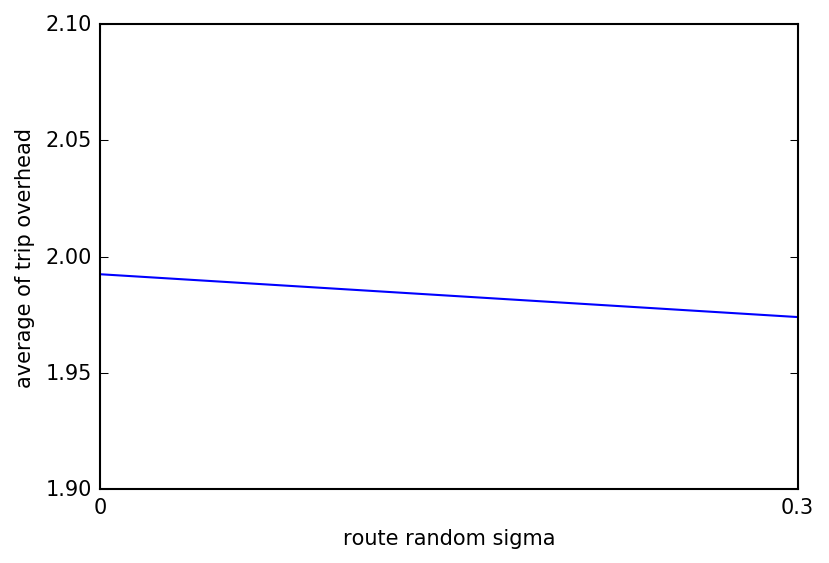

exploration_percentage
---------
0.3: 2.01034621283
0: 1.95619448335


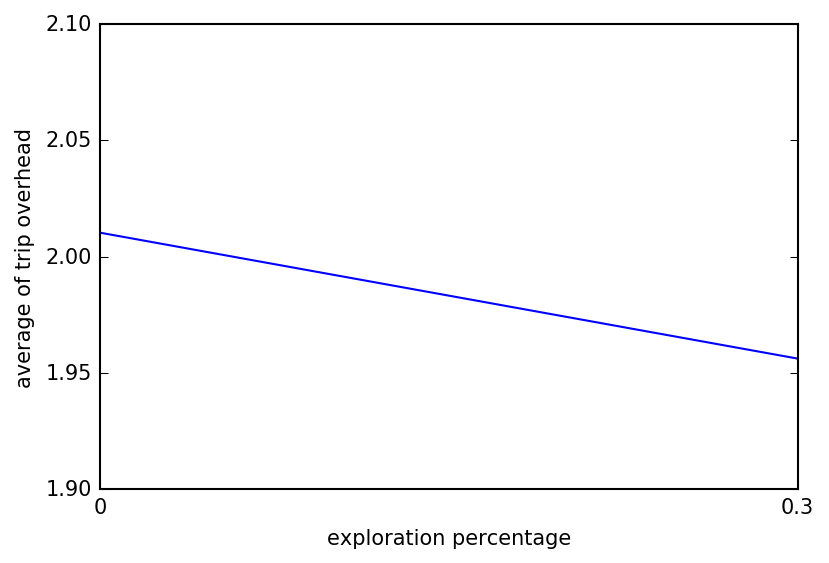

max_speed_and_length_factor
---------
1: 2.04041074598
2.5: 1.92612995019


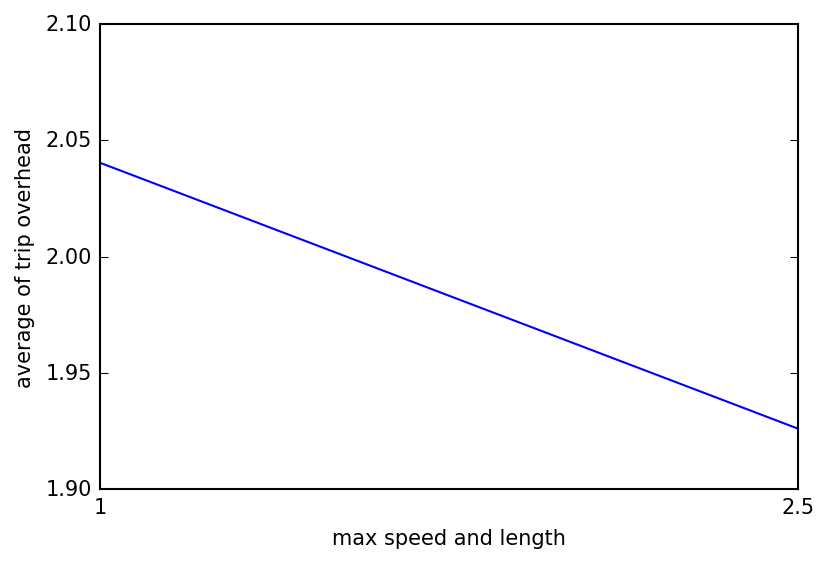

average_edge_duration_factor
---------
1: 1.96574892685
2.5: 2.00079176933


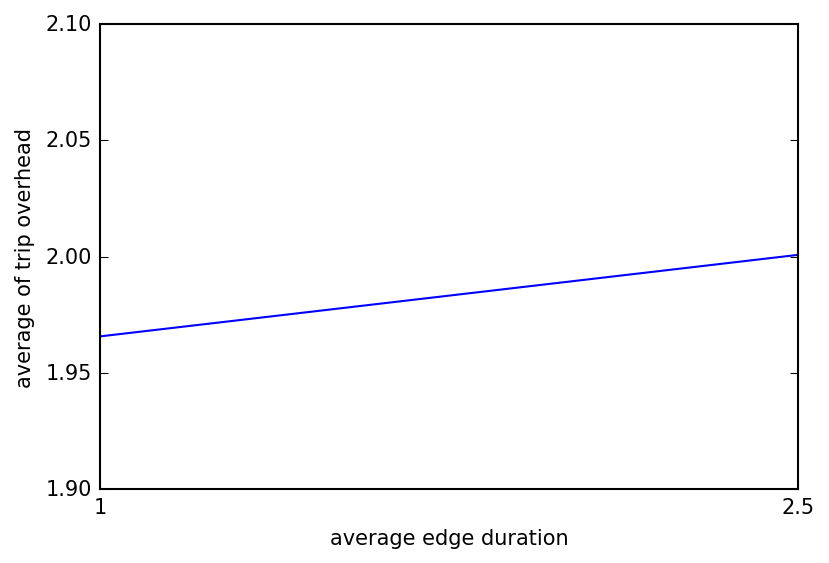

freshness_update_factor
---------
5: 1.93658670957
20: 2.02995398661


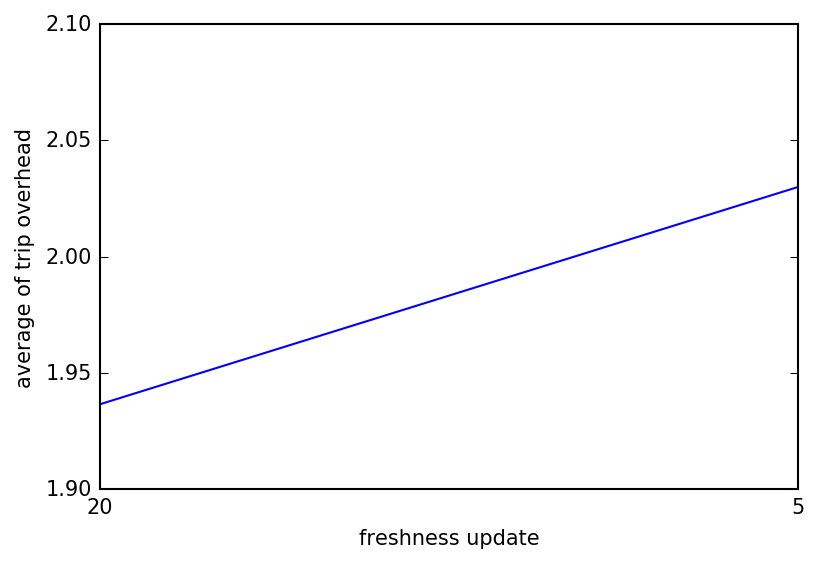

freshness_cut_off_value
---------
100: 2.03225483708
700: 1.9342858591


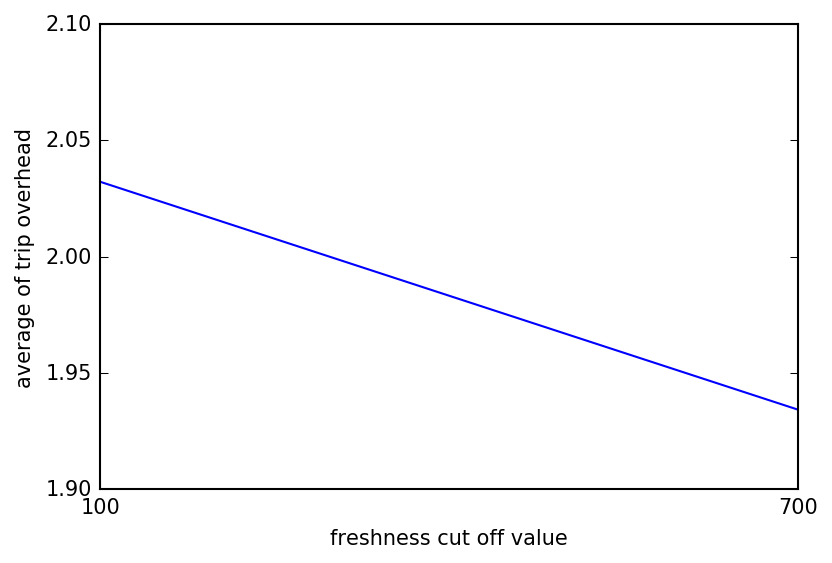

re_route_every_ticks
---------
10: 1.96354318799
70: 2.00299750819


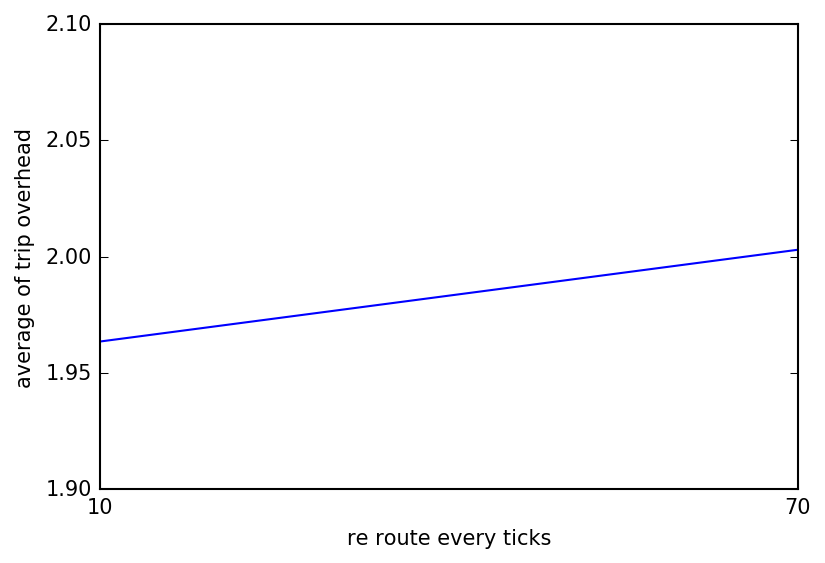

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

print "starting plotting..."
# print len(analysis_data)
# print len(analysis_knobs)

# print len(analysis_data[0])
# print len(analysis_knobs[0])

# print analysis_data[0][:3]
# print analysis_knobs[0][:3]

knob_names = [
    "route_random_sigma",
    "exploration_percentage",
    "max_speed_and_length_factor",
    "average_edge_duration_factor",
    "freshness_update_factor",
    "freshness_cut_off_value",
    "re_route_every_ticks",
]

knob_values = [
    [0, 0.3],     # route_random_sigma
    [0, 0.3],     # exploration_percentage
    [1, 2.5],     # max_speed_and_length_factor
    [1, 2.5],     # average_edge_duration_factor
    [5, 20],      # freshness_update_factor
    [100, 700],   # freshness_cut_off_value
    [10, 70]      # re_route_every_ticks"
]

knobs = {}
data = {}

for j in range(len(knob_names)): 
    knob_name = knob_names[j]
    print knob_name 
    print "---------"
    for i in knob_values[j]:    
        print "*******"
        ind = knob_name + ":" + str(i)
        knobs[ind] = []
        data[ind] = []
        for knob_ind in range(len(analysis_knobs)):
            if analysis_knobs[knob_ind][0].get(knob_name)==i:
                knobs[ind] += [i for k in analysis_knobs[knob_ind]]       
                data[ind] += analysis_data[knob_ind]
    
        print str(i)+"'s: " + str(len(data[ind]))
    print "========="
    
# print len(knobs)
# print len(data)

# for k in knobs.keys():
#     print k

for name in knob_names:
    print name 
    print "---------"
    figure_keys = []
    figure_values = []
    for k in knobs.keys():
        
        ks = k.split(":")
        if ks[0] == name:
            figure_keys.append(ks[1])
            overheads = [d["overhead"] for d in data[k]]
            figure_values.append(sum(overheads) / len(overheads))
            print str(ks[1]) + ": " + str(sum(overheads) / len(overheads))

    keys = [i for i in range(0, len(figure_keys))]
    plt.plot(keys,figure_values)
#     plt.plot(figure_keys,figure_values)
    if "factor" in name: 
        name = name.split("factor")[0]
        name = name[:len(name)-1]
    plt.xlabel(name.replace("_", " "))
    plt.ylabel('average of trip overhead')
    axes = plt.gca()
    axes.set_ylim([1.9,2.1])
    plt.xticks(keys, sorted(figure_keys))
    plt.show()


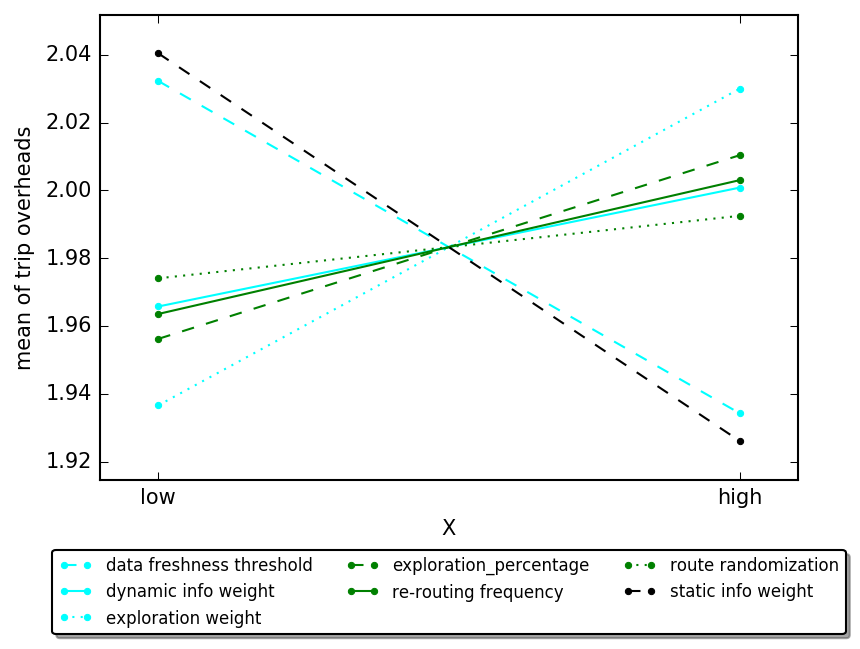

In [7]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

def get_id_for_knob2(knob):
    if knob == "route_random_sigma":
        return "route randomization"
    if knob == "exploration_percentage":
        return "exploration_percentage"
    if knob == "max_speed_and_length_factor":
        return "static info weight"
    if knob == "average_edge_duration_factor":
        return "dynamic info weight"
    if knob == "freshness_update_factor":
        return "exploration weight"
    if knob == "freshness_cut_off_value":
        return "data freshness threshold"
    if knob == "re_route_every_ticks":
        return "re-routing frequency"
    
def get_normalized_list(knob_list):
    l = []
    for knob_v in knob_list: 
        if knob_v == 0:
            l.append(0)
        if knob_v == 1:
            l.append(0)
        if knob_v == 5:
            l.append(0)
        if knob_v == 10:
            l.append(0)
        if knob_v == 100:
            l.append(0)
        if knob_v == 0.3:
            l.append(1)
        if knob_v == 2.5:
            l.append(1)
        if knob_v == 20:
            l.append(1)
        if knob_v == 70:
            l.append(1)
        if knob_v == 700:
            l.append(1)
    return l
   
all_knobs = []
for knob_list in knobs.values():
    all_knobs += get_normalized_list(knob_list)

all_traces = []
for k in knobs.keys():
    all_traces += [get_id_for_knob2(k.split(":")[0]) for i in range(len(knobs[k]))]

all_data = []
for data_list in data.values():
    all_data += [d["overhead"] for d in data_list]


fig = interaction_plot(all_knobs, all_traces, all_data,
                       linestyles=['--',  '-', ':',  '--',  '-',':', '--',],
                      colors=['cyan', 'cyan', 'cyan', 'green', 'green', 'green', 'black'])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=3, fancybox=True, shadow=True, prop={'size': 8})
plt.ylabel('mean of trip overheads')
plt.xticks([0,1], ["low", "high"])
plt.show()

### Just a test

In [ ]:
import random

d1 = {0: [2,5,9], 1: [3,4,8]}
d2 = {0: [2,5,9], 1: [3,4,8]}
d3 = {0: [3,3,9], 1: [6,8,8]}

print "data1: " + str(d1)
print "data2: " + str(d2)
print "data3: " + str(d3)

all_d = {}
for i in range(len(d1)): 
    all_d[i] = d1[i] + d2[i] + d3[i]
    
ind = random.sample(range(3), 2)
print ind

print all_d[0]
print [all_d[0][i] for i in ind]